<a href="https://colab.research.google.com/github/JHyunjun/SNU/blob/main/VGGNet_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Part 2: Training VGGNet and ResNet


Copyright (C) Data Science & AI Laboratory, Seoul National University. This material is for educational uses only. Some contents are based on the material provided by other paper/book authors and may be copyrighted by them. 

Now, you're going to leave behind your implementations and instead migrate to one of popular deep learning frameworks, **TensorFlow**. <br>
In this notebook, you will learn the base structure of VGGNet and ResNet <br>
There are **2 sections**, and in each section, you need to follow the instructions to complete the skeleton codes.

1. [Construct VGGNet](#1)
2. [Construct ResNet](#2)

**Note**: certain details are missing or ambiguous on purpose, in order to test your knowledge on the related materials. However, if you really feel that something essential is missing and cannot proceed to the next step, then contact the teaching staff with clear description of your problem.

### Some helpful tutorials and references for assignment #2:
- [1] TensorFlow official tutorials. [[link]](https://www.tensorflow.org/get_started/get_started)
- [2] Stanford CS231n lectures. [[link]](http://cs231n.stanford.edu/)
- [3] Iandola et al, "SqueezeNet: AlexNet-level accuracy with 50x fewer parameters and < 0.5MB model size", arXiv 2016. [[pdf]](https://arxiv.org/pdf/1602.07360.pdf)
- [4] Simonyan et al., "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014. [[pdf]](https://arxiv.org/pdf/1312.6034.pdf)
- [5] Szegedy et al., "Intriguing properties of neural networks", ICLR 2014. [[pdf]](https://arxiv.org/pdf/1312.6199.pdf)
- [6] Szegedy et al., "Going deeper with convolutions", CVPR 2015. [[pdf]](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)
- [7] Yosinski et al., "Understanding Neural Networks Through Deep Visualization", ICML Workshop 2015. [[pdf]](http://yosinski.com/media/papers/Yosinski__2015__ICML_DL__Understanding_Neural_Networks_Through_Deep_Visualization__.pdf)
- [8] He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
- [9] Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." arXiv preprint arXiv:1409.1556 (2014).

## Load datasets
The CIFAR-10 dataset will be downloaded automatically if it is not located in the *Utils* directory. <br>

In [1]:
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

import pathlib
import shutil
import tempfile


In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D
from tensorflow.keras import Model
import matplotlib.pyplot as plt

import os
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
def _deprocess_image(img, MEAN, STD):
    """ Undo preprocessing on an image and convert back to uint8. """
    return np.clip(255 * (img * STD + MEAN), 0.0, 255.0).astype(np.uint8)

def _preprocess_image(img, MEAN, STD):
    """ Preprocess an image: subtracts the pixel mean and divides by the standard deviation.  """
    return (img.astype(np.float32)/255.0 - MEAN) / STD

def plot_images(X, Y, C, idx=0, Each_Category=False, SaliencyMaps=None, ClassRepresentatve=None, Adversarial=None, Target_y=None):
    ''' Plot images '''
    if Each_Category:
        Category = set(Y)
        for i in range(10):
            while(1):
                if Y[idx] in Category:
                    Category.remove(Y[idx])
                    break
                else:
                    idx += 1
            
            plt.subplot(2, 5, Y[idx]+1)
            plt.imshow(_deprocess_image(X[idx], CIFAR10_MEAN, CIFAR10_STD))
            plt.title(C[Y[idx]])
            plt.axis('off')
            
    elif SaliencyMaps is not None:    
        for i in range(5):
            plt.subplot(2, 5, i+1)
            plt.imshow(X[idx+i])
            plt.title(C[Y[idx+i]])
            plt.axis('off')
            
            plt.subplot(2, 5, i+6)
            plt.imshow(SaliencyMaps[idx+i], cmap=plt.cm.hot)
            plt.title(C[Y[idx+i]])
            plt.axis('off')
            
    elif ClassRepresentatve is not None:    
        Iter = int(X.shape[0] / 4)
        for i in range(4):
            plt.subplot(2, 2, i+1)
            plt.imshow(X[Iter*(i+1)])
            plt.title('%s\nIteration %d' % (C[Y], Iter*(i+1)))
            plt.axis('off')
            plt.gcf().set_size_inches(8, 8)
            
    elif Adversarial is not None:
        plt.subplot(1, 4, 1)
        plt.imshow(X[0])
        plt.title(C[Y[0]])
        plt.axis('off')
        
        plt.subplot(1, 4, 2)
        plt.imshow(Adversarial[0])
        plt.title(C[Target_y])
        plt.axis('off')
        
        plt.subplot(1, 4, 3)
        plt.title('Difference')
        plt.imshow((X-Adversarial)[0])
        plt.axis('off')
        
        plt.subplot(1, 4, 4)
        plt.title('Magnified difference (10x)')
        plt.imshow(10 * (X-Adversarial)[0])
        plt.axis('off')          
        
    else:
        for i in range(5):
            plt.subplot(1, 5, i+1)
            plt.imshow(X[idx+i])
            plt.title(C[Y[idx+i]])
            plt.axis('off')
    plt.show()

170508288/170498071 [==============================] - 3s 0us/step
Train data shape (40000, 32, 32, 3)
Train labels shape (40000, 1)
Validation data shape (10000, 32, 32, 3)
Validataion labels shape (10000, 1)
Test data shape (10000, 32, 32, 3)
Test labels shape (10000, 1)


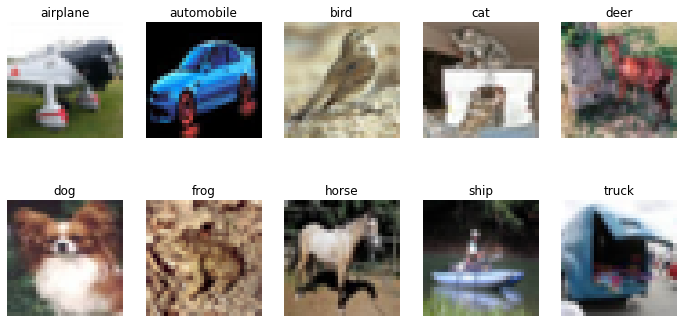

In [5]:
from sklearn.model_selection import train_test_split
(X_train, Y_train),(X_test, Y_test)= tf.keras.datasets.cifar10.load_data()
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2)
print('Train data shape ' + str(X_train.shape))
print('Train labels shape ' + str(Y_train.shape))
print('Validation data shape ' + str(X_val.shape))
print('Validataion labels shape ' + str(Y_val.shape))
print('Test data shape ' + str(X_test.shape))
print('Test labels shape ' + str(Y_test.shape))

#Normalizing
CIFAR10_MEAN = np.mean(X_train.astype(np.float32)/255.0, axis=0)
CIFAR10_STD = np.std(X_train.astype(np.float32)/255.0, axis=0)

X_train = np.array([_preprocess_image(img, CIFAR10_MEAN, CIFAR10_STD) for img in X_train])
X_val   = np.array([_preprocess_image(img, CIFAR10_MEAN, CIFAR10_STD) for img in X_val])
X_test  = np.array([_preprocess_image(img, CIFAR10_MEAN, CIFAR10_STD) for img in X_test])

Class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_images(X_train, Y_train[:,0], Class_names, Each_Category=True)

In [6]:
BATCH_SIZE=200
N_VALIDATION = len(Y_val)
N_TRAIN = len(Y_train)
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
train_ds= tf.data.Dataset.from_tensor_slices(
    (X_train, Y_train)).cache().shuffle(len(Y_train)).batch(BATCH_SIZE)
val_ds= tf.data.Dataset.from_tensor_slices(
    (X_val, Y_val)).cache().batch(BATCH_SIZE)
test_ds= tf.data.Dataset.from_tensor_slices(
    (X_test, Y_test)).cache().batch(BATCH_SIZE)

## <a name="1"></a> 1. Construct VGGNet

In this section, you will learn how to define  VGGNet, train the model, and evaluate its performance on the validation dataset. The goal here isn't to get good performance (that'll be next), but instead to get comfortable with understanding the TensorFlow and configuring VGGNet.

Using the code provided as guidance, **(1) define**, **(2) train**, and **(3) evaluate**

In [7]:
def regularized_padded_conv(*args, **kwargs):
    return tf.keras.layers.Conv2D(*args, **kwargs, padding='same', kernel_regularizer=_regularizer,
                                  kernel_initializer='he_normal', use_bias=False)
    
def regularized_padded_conv3(*args, **kwargs):
    return tf.keras.layers.Conv2D(*args, **kwargs, kernel_size=3, kernel_regularizer=_regularizer,
                                  padding='same', kernel_initializer='he_normal')
    
def bn_relu(x):
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.ReLU()(x)

In [184]:
def conv_block(x, num_blocks, filters, pool):
  #filters = features(output channel)
  #num_blocks = group_size
  #pool = pools(pooling size)
    print(filters)
    x = tf.keras.layers.Conv2D(filters, padding = 'same', kernel_size = 3, kernel_initializer = 'he_normal',
                                kernel_regularizer = _regularizer, use_bias = False)(x)                         
    for i in range(num_blocks-1) : 
      x = tf.keras.layers.Conv2D(filters, padding='same', kernel_size = 3, 
                                 kernel_regularizer=_regularizer, kernel_initializer = 'he_normal', 
                                 use_bias = False)(x)
      x = tf.keras.layers.BatchNormalization()(x)
      x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size = pool, strides = 2)(x)
    return x

def VGG(input_shape, n_classes, l2_reg=2.5e-4, group_sizes=(2, 2, 3, 3, 3),
           features=(64, 128, 256, 512, 512), pools=(2, 2, 2, 2, 2)):
    global _regularizer
    _regularizer = tf.keras.regularizers.l2(l2_reg) #l2 Regularizer
    inputs = tf.keras.layers.Input(shape=input_shape)

    flow = inputs
    for group_size, feature, pool in zip(group_sizes, features, pools):
        flow = conv_block(flow, num_blocks = group_size, filters = feature, pool = pool)
    
    pooled = tf.keras.layers.GlobalAveragePooling2D()(flow)
    output = tf.keras.layers.Dense(n_classes, kernel_regularizer = _regularizer)(pooled)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    return model

In [185]:
def cifar_vgg16(load_weights=False, l2_reg=2.5e-4):
    model = VGG(input_shape=(32, 32, 3), n_classes=10, l2_reg=l2_reg, group_sizes=(2, 2, 3, 3, 3), 
                features=(64, 128, 256, 512, 512), pools=(2, 2, 2, 2, 2))
    if load_weights: model = load_weights_func(model, 'cifar_vgg16')
    return model

In [186]:
tf.keras.backend.clear_session()
VGGNET = cifar_vgg16()  

VGGNET.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

VGGNET.fit(train_ds, validation_data=val_ds, epochs=2)
VGGNET.evaluate(test_ds)

64
128
256
512
512
Epoch 1/2


KeyboardInterrupt: ignored

## <a name="2"></a>2. Construct ResNet 
In this section, you will implement ResNet. <br>


In [ ]:
def shortcut(x, filters, stride):
    if x.shape[-1] == filters:
        return x
    else:
        x = regularized_padded_conv(filters, 1, strides=stride)(x)
        return x
    

def original_block(x, filters, stride=1, **kwargs):
    ##############################################################################
    #                          IMPLEMENT YOUR CODE                               #
    ##############################################################################
    pass
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    

def group_of_blocks(x, num_blocks, filters, stride, block_idx=0):
    x = original_block(x, filters, stride)
    for i in range(num_blocks-1):
        x = original_block(x, filters)
    return x

In [ ]:
def Resnet(input_shape, n_classes, l2_reg=1e-4, group_sizes=(2,2,2,2), features=(1, 2, 2, 2), strides=(1, 2, 2, 2),
            first_conv={"filters": 64, "kernel_size": 3, "strides": 1}):
    global _regularizer
    _regularizer = tf.keras.regularizers.l2(l2_reg)
    
    inputs = tf.keras.layers.Input(shape=input_shape)
    flow = regularized_padded_conv(**first_conv)(inputs)
    
    flow = bn_relu(flow)
    
    for block_idx, (group_size, feature, stride) in enumerate(zip(group_sizes, features, strides)):
        flow = # To Do
    
    flow = bn_relu(flow)
    
    flow = tf.keras.layers.GlobalAveragePooling2D()(flow)
    outputs = # To DO
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
def cifar_resnet18(l2_reg=1e-4, load_weights=False):
    model = Resnet(input_shape=(32, 32, 3), n_classes=10, l2_reg=l2_reg, group_sizes=(2,2,2,2), features=(64,128,256,512),
                   strides=(1, 2, 2, 2), first_conv={"filters": 64, "kernel_size": 3, "strides": 1})
    return model

In [ ]:
tf.keras.backend.clear_session()
RESNET = cifar_resnet18()

RESNET.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

RESNET.fit(train_ds, validation_data=val_ds, epochs=2)
RESNET.evaluate(test_ds)